# 2d Diffusion problem

**Python for HPC course**

Max Planck Computing and Data Facility, Garching

## Example: Diffusion Equation

* toy problem: (constant) diffusion on a 2d periodic grid $u_t = \alpha \Delta u$
* finite difference Laplacian operator, 5-point stencil, explicit time stepping, periodic boundary conditions
* formula for time update of $u$ at position $x_i,y_j$ from time $t_n$ to $t_{n+1}$:

$$ u_{i,j}^{(n+1)} = u_{i,j}^{(n)} + \frac{\alpha \Delta t}{\Delta x^2} \left( 
u_{i-1,j}^{(n)}
+u_{i+1,j}^{(n)}
+u_{i,j-1}^{(n)}
+u_{i,j+1}^{(n)}
-4u_{i,j}^{(n)}
\right) $$

* 5pt stencil on a regular grid
* grid boundary of width 1 serves as "ghost cells" for periodic BCs
![5pt Stencil](fig/stencil_5pt.svg)

## Example: Diffusion Equation

### discuss and compare various approaches

* naive Python implementation
* SciPy's Laplacian
* several NumPy variants
* Cython
* Numba
* Fortran implementation
* add multithreading

In [1]:
import os
# limit the number of OMP threads to 1 before importing NumPy to better
# pinpoint the difference between sequential and parallel computation
for VAR in ["OMP_NUM_THREADS"]:
    os.environ[VAR]="1"
    print("{}={}".format(VAR, os.environ[VAR]))
# OMP_NUM_THREADS is now valid for NumPy which may use OpenMP internally via its backends (e.g. MKL)
import numpy as np

OMP_NUM_THREADS=1


In [2]:
%matplotlib inline

## Infrastructure code: parameters, init(), main_loop()

In [3]:
# parameters (global, for convenience)
n_iterations = 10
n_points = 128
dt = 0.15
D = 1.25

In [4]:
def init(val=0.5, with_ghosts=True):
    """Set up a 2d NumPy array with some initial value pattern."""
    x = np.linspace(0., 4.*np.pi, num=n_points+2)
    y = np.linspace(0., 4.*np.pi, num=n_points+2)
    grid = val * np.outer(np.sin(x)**4, np.sin(y)**4)
    if with_ghosts:
        return grid
    else:
        return grid[1:-1,1:-1]

In [5]:
def main_loop(evolve_func, grid):
    """Main loop function, calling evolve_func on grid."""
    grid_tmp = np.empty_like(grid)
    for i in range(1, n_iterations+1):
        evolve_func(grid, grid_tmp, n_points, dt, D)
        # swap references (do not copy data)
        grid_swap = grid
        grid = grid_tmp
        grid_tmp = grid_swap
    return grid

## Initial condition, expected evolved solution
![matplotlib diffusion plot](./fig/diffusion_plot.png)

## A naive pure Python implementation

In [6]:
def apply_periodic_bc_python(grid, n_points):
    """Explicitly apply periodic boundary conditions, via Python loops."""
    for j in range(n_points + 2):
        grid[ 0, j] = grid[-2, j]
        grid[-1, j] = grid[ 1, j]
    for i in range(n_points + 2):
        grid[ i,-1] = grid[ i, 1]
        grid[ i, 0] = grid[ i,-2]

In [7]:
def evolve_python(grid, grid_tmp, n_points, dt, D):
    apply_periodic_bc_python(grid, n_points)
    for i in range(1, n_points+1):
        for j in range(1, n_points+1):
            # stencil formula
            grid_tmp[i, j] = grid[i, j] + dt * D * \
                (grid[i-1, j] + grid[i+1, j] + grid[i, j-1] + grid[i, j+1] - 4.0 * grid[i, j])

In [8]:
%%time
grid = init()
solution_python = main_loop(evolve_python, grid)
# note the very small problem size at this point

CPU times: user 204 ms, sys: 272 µs, total: 204 ms
Wall time: 203 ms


## SciPy's Laplacian operator

In [9]:
from scipy.ndimage import laplace as scipy_laplacian

def evolve_scipy(grid, grid_tmp, n_points, dt, D):
    """Time step based on the SciPy Laplacian."""
    grid_tmp[:] = grid + dt * D * scipy_laplacian(grid, mode='wrap')

/tmp/ipykernel_905254/1329358556.py:1: DeprecationWarning: Please use `laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import laplace as scipy_laplacian


In [10]:
%%time
grid = init(with_ghosts=False)
solution_scipy = main_loop(evolve_scipy, grid)

CPU times: user 5.22 ms, sys: 130 µs, total: 5.35 ms
Wall time: 3.97 ms


In [11]:
# increase the problem size for the experiments below, not considering plain Python anymore
n_iterations = 2000
n_points = 768
# expected scaling of run time: ~ n_iterations * n_points**2

In [12]:
%%time
grid = init(with_ghosts=False)

CPU times: user 4.35 ms, sys: 445 µs, total: 4.79 ms
Wall time: 4.61 ms


In [13]:
%%time
grid = init(with_ghosts=False)
solution_scipy = main_loop(evolve_scipy, grid)

CPU times: user 14.3 s, sys: 6.15 s, total: 20.5 s
Wall time: 20.5 s


### A look at the result

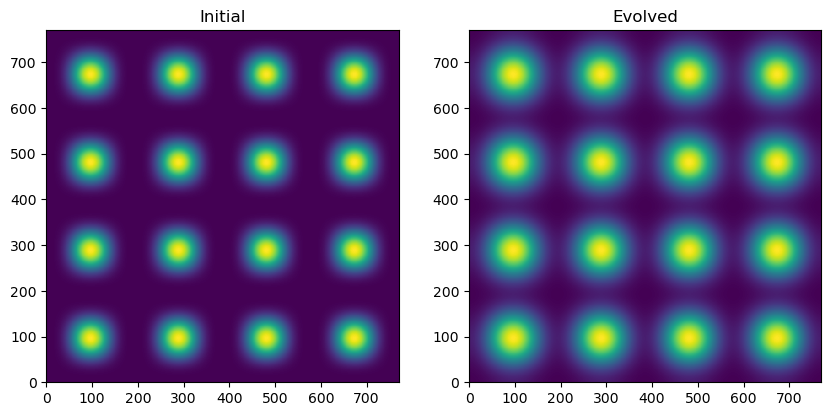

In [14]:
import matplotlib.pyplot as plt

def plot_grids(initial_grid, evolved_grid):
    f = plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.pcolormesh(initial_grid.T)
    plt.axis('image')
    plt.title('Initial')
    plt.subplot(122)
    plt.pcolormesh(evolved_grid.T)
    plt.axis('image')
    l = plt.title('Evolved')

plot_grids(init(), solution_scipy)

## Can we achieve better performance than SciPy?

## NumPy experiments

### Laplacian implementation using NumPy's roll function
* roll() shifts an array by an offset along an axis
* elements that roll beyond the array limits enter back in from the other side

In [15]:
def laplacian_np_roll(grid):
    """Laplacian implementation based on the NumPy roll functionality."""
    return np.roll(grid, +1, 0) + np.roll(grid, -1, 0) \
         + np.roll(grid, +1, 1) + np.roll(grid, -1, 1) \
         - 4 * grid

def evolve_np_roll(grid, grid_tmp, n_points, dt, D):
    """Time step based on the NumPy-roll-Laplacian."""
    grid_tmp[:] = grid + dt * D * laplacian_np_roll(grid)

In [16]:
%%time
grid = init(with_ghosts=False)
solution_roll = main_loop(evolve_np_roll, grid)

CPU times: user 12.1 s, sys: 13.6 ms, total: 12.1 s
Wall time: 12.1 s


In [ ]:
assert(np.allclose(solution_scipy, solution_roll))

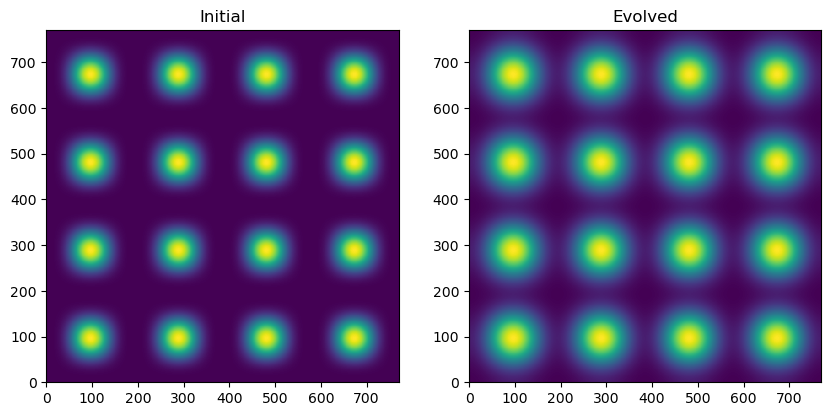

In [17]:
plot_grids(init(with_ghosts=False), solution_roll)

In [18]:
# a potentially more memory-efficient implementation
def evolve_np_inplace_roll(grid, grid_tmp, n_points, dt, D):
    # time step
    grid_tmp[:] = -4.0 * grid
    grid_tmp += np.roll(grid, +1, 0)
    grid_tmp += np.roll(grid, -1, 0)
    grid_tmp += np.roll(grid, +1, 1)
    grid_tmp += np.roll(grid, -1, 1)
    grid_tmp *= dt * D
    grid_tmp += grid

In [19]:
%%time
grid = init(with_ghosts=False)
solution_roll = main_loop(evolve_np_inplace_roll, grid)

CPU times: user 12.2 s, sys: 18 ms, total: 12.2 s
Wall time: 12.2 s


In [ ]:
assert(np.allclose(solution_scipy, solution_roll))

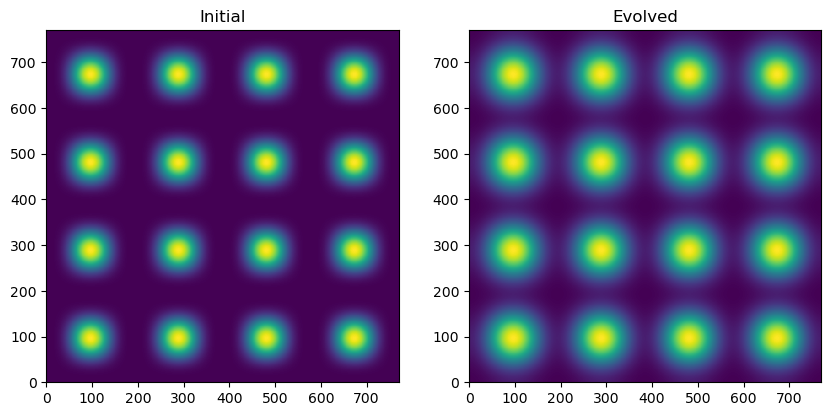

In [20]:
plot_grids(init(with_ghosts=False), solution_roll)

### NumPy slicing notation

In [21]:
# without np.roll() we need to handle the periodicity explicitly
def apply_periodic_bc(grid):
    """Explicitly apply periodic boundary conditions, using NumPy ranges."""
    grid[ 0, :] = grid[-2, :]
    grid[-1, :] = grid[ 1, :]
    grid[ :,-1] = grid[ :, 1]
    grid[ :, 0] = grid[ :,-2]

In [ ]:
grid = init(with_ghosts=True)

In [22]:
%%time
apply_periodic_bc_python(grid, n_points)

CPU times: user 569 µs, sys: 85 µs, total: 654 µs
Wall time: 659 µs


In [ ]:
grid = init(with_ghosts=False)

In [23]:
%%time
apply_periodic_bc(grid)

CPU times: user 44 µs, sys: 7 µs, total: 51 µs
Wall time: 108 µs


In [24]:
def evolve_np_slicing(grid, grid_tmp, n_points, dt, D):
    """Time step based on an explicitly coded Laplacian using array slicing."""
    apply_periodic_bc(grid)
    grid_tmp[1:-1, 1:-1] = grid[1:-1, 1:-1] \
                     + dt * D * (   grid[0:-2, 1:-1] + grid[2:  , 1:-1] \
                                  + grid[1:-1, 0:-2] + grid[1:-1, 2:  ] \
                                  - 4.0 * grid[1:-1, 1:-1] )

In [25]:
%%time
grid = init(with_ghosts=True)
solution_np_slicing = main_loop(evolve_np_slicing, grid)

CPU times: user 9.7 s, sys: 12.8 ms, total: 9.71 s
Wall time: 9.71 s


In [ ]:
assert(np.allclose(solution_scipy, solution_np_slicing[1:-1,1:-1]))

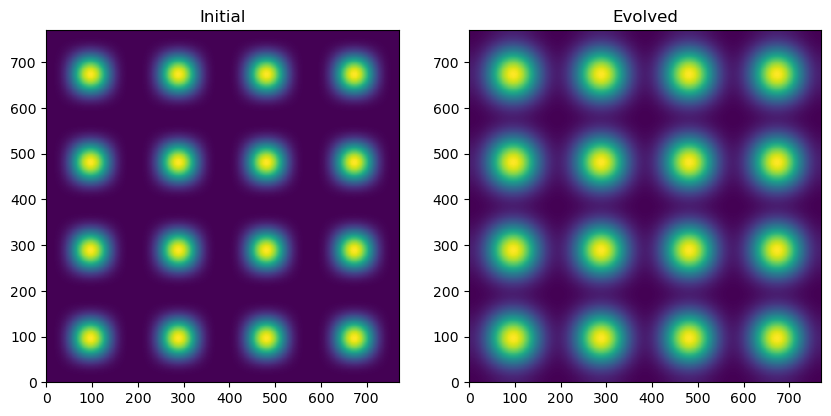

In [26]:
plot_grids(init(), solution_np_slicing)

In [27]:
def evolve_np_inplace_slicing(grid, grid_tmp, n_points, dt, D):
    apply_periodic_bc(grid)
    grid_tmp[1:-1, 1:-1] = -4.0 * grid[1:-1, 1:-1]
    grid_tmp[1:-1, 1:-1] += grid[0:-2, 1:-1]
    grid_tmp[1:-1, 1:-1] += grid[2:  , 1:-1]
    grid_tmp[1:-1, 1:-1] += grid[1:-1, 0:-2]
    grid_tmp[1:-1, 1:-1] += grid[1:-1, 2:  ]
    grid_tmp[1:-1, 1:-1] *= dt * D
    grid_tmp[1:-1, 1:-1] += grid[1:-1, 1:-1]

In [28]:
%%time
grid = init(with_ghosts=True)
solution_np_slicing = main_loop(evolve_np_inplace_slicing, grid)

CPU times: user 15.3 s, sys: 7.62 ms, total: 15.3 s
Wall time: 15.3 s


In [ ]:
assert(np.allclose(solution_scipy, solution_np_slicing[1:-1,1:-1]))

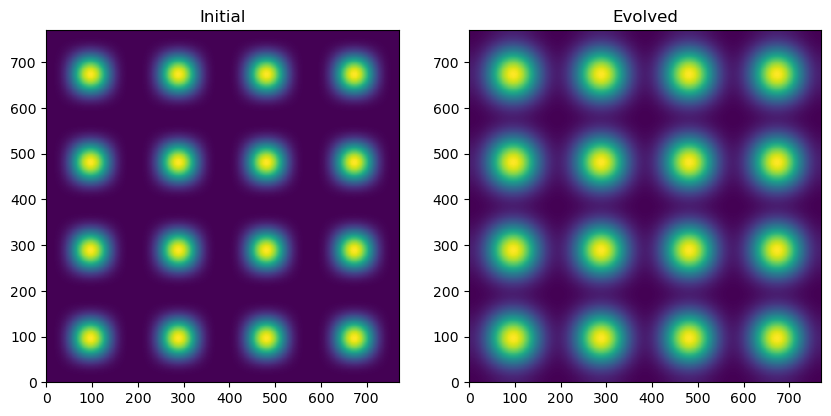

In [29]:
plot_grids(init(), solution_np_slicing)

## Introducing compiled code using Cython
* goal: push as much code as possible into the compiled layer

### first attempt: naive compilation
* let's start with the Python loop-based implementation

In [30]:
%load_ext Cython

In [31]:
%%cython -c=-O3 -c=-march=native -c=-ffast-math

def apply_periodic_bc_cython(grid, n_points):
    for j in range(n_points + 2):
        grid[ 0, j] = grid[-2, j]
        grid[-1, j] = grid[ 1, j]
    for i in range(n_points + 2):
        grid[ i,-1] = grid[ i, 1]
        grid[ i, 0] = grid[ i,-2]

def evolve_cython(grid, grid_tmp, n_points, dt, D):
    apply_periodic_bc_cython(grid, n_points)
    for i in range(1, n_points+1):
        for j in range(1, n_points+1):
            # stencil formula
            grid_tmp[i, j] = grid[i, j] + dt * D * (
                grid[i-1, j] + grid[i+1, j] + grid[i, j-1] + grid[i, j+1]
                - 4.0 * grid[i, j])

### Naive compilation
* Simply applying the Cython compiler to plain Python code does not speed it up!
* We need to guide Cython by adding type declarations to generate efficient code.

In [32]:
%%time
grid = init(with_ghosts=True)
#main_loop(evolve_cython, grid)

# measured wall clock time during lunch break: 25 minutes!!!

CPU times: user 3.11 ms, sys: 285 µs, total: 3.39 ms
Wall time: 2.25 ms


## Cython 'annotate' optimization guidance
* Cython is able to create a colorized output of the source, where interaction with Python code and other inefficiencies are highlighted
* out goal is to get rid of any yellow in the output
* invocation from the command line, generates HTML file  
  `cythonize --annotate source.pyx`
* invocation from Jupyter via the `--annotate` flag, see below

In [33]:
%%cython -c=-O3 -c=-march=native -c=-ffast-math --annotate

def apply_periodic_bc_cython(grid, n_points):
    for j in range(n_points + 2):
        grid[ 0, j] = grid[-2, j]
        grid[-1, j] = grid[ 1, j]
    for i in range(n_points + 2):
        grid[ i,-1] = grid[ i, 1]
        grid[ i, 0] = grid[ i,-2]

def evolve_cython(grid, grid_tmp, n_points, dt, D):
    apply_periodic_bc_cython(grid, n_points)
    for i in range(1, n_points+1):
        for j in range(1, n_points+1):
            # stencil formula
            grid_tmp[i, j] = grid[i, j] + dt * D * (
                grid[i-1, j] + grid[i+1, j] + grid[i, j-1] + grid[i, j+1]
                - 4.0 * grid[i, j])

### Cython, step 1: Adding type information
* to enable Cython to create efficient C code, we need to add data type declarations
    * function parameters (e.g. declare parameters as `np.ndarray`, `int`, `double`)
    * function body (e.g. declare variables as `cdef int`)
* function declarations (no impact on performance)
    * `def`: Python function, takes Python objects as parameters and returns Python objects
    * `cdef`: C function, not callable from Python, takes C values or Python objects as parameters and returns C values or Python objects
    * `cpdef`: hybrid C and Python function
* note that at this point we break Python source code compatibility

In [34]:
%%cython -c=-O3 -c=-march=native -c=-ffast-math --annotate

import numpy as np
cimport numpy as np

cdef apply_periodic_bc_cython(np.ndarray grid, int n_points):
    cdef int i, j
    for j in range(n_points + 2):
        grid[ 0, j] = grid[-2, j]
        grid[-1, j] = grid[ 1, j]
    for i in range(n_points + 2):
        grid[ i,-1] = grid[ i, 1]
        grid[ i, 0] = grid[ i,-2]

def evolve_cython(np.ndarray grid, np.ndarray grid_tmp, int n_points, double dt, double D):
    cdef int i, j
    apply_periodic_bc_cython(grid, n_points)
    for i in range(1, n_points+1):
        for j in range(1, n_points+1):
            # stencil formula
            grid_tmp[i, j] = grid[i, j] + dt * D * (
                grid[i-1, j] + grid[i+1, j] + grid[i, j-1] + grid[i, j+1]
                - 4.0 * grid[i, j])

### Cython, step 2: Efficient indexing
* until now, each array access `[]` implies Python interaction
* to enable efficient indexing at C speed, we need to specify for NumPy arrays
    * dimensionality
    * native datatype
    * $\to$ add `np.ndarray[np.float64_t, ndim=2]` to our code

In [35]:
%%cython -c=-O3 -c=-march=native -c=-ffast-math --annotate

import numpy as np
cimport numpy as np

cdef apply_periodic_bc_cython(np.ndarray[np.float64_t, ndim=2] grid, int n_points):
    cdef int i, j
    for j in range(n_points + 2):
        grid[ 0, j] = grid[-2, j]
        grid[-1, j] = grid[ 1, j]
    for i in range(n_points + 2):
        grid[ i,-1] = grid[ i, 1]
        grid[ i, 0] = grid[ i,-2]

def evolve_cython(np.ndarray[np.float64_t, ndim=2] grid, np.ndarray[np.float64_t, ndim=2] grid_tmp,
                  int n_points, double dt, double D):
    cdef int i, j
    apply_periodic_bc_cython(grid, n_points)
    for i in range(1, n_points+1):
        for j in range(1, n_points+1):
            # stencil formula
            grid_tmp[i, j] = grid[i, j] + dt * D * (
                grid[i-1, j] + grid[i+1, j] + grid[i, j-1] + grid[i, j+1]
                - 4.0 * grid[i, j])

### Cython, step 3: Tuning indexing further
Until now, each indexing `[]` operation is capable of
* bounds checking
* handling of negative indices

After careful checking, we may disable these features via decorators to gain additional speed. However, we need to remove the negative indices from the code at this point.

In [36]:
%%cython -c=-O3 -c=-march=native -c=-ffast-math --annotate

import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping
cpdef apply_periodic_bc_cython(np.ndarray[np.float64_t, ndim=2] grid, int n_points):
    cdef int i, j
    for j in range(n_points + 2):
        grid[         0, j] = grid[n_points, j]  # grid[ 0, j] = grid[-2, j]
        grid[n_points+1, j] = grid[       1, j]  # grid[-1, j] = grid[ 1, j]
    for i in range(n_points + 2):
        grid[ i, n_points+1] = grid[ i,        1]  # grid[ i,-1] = grid[ i, 1]
        grid[ i,          0] = grid[ i, n_points]  # grid[ i, 0] = grid[ i,-2]

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping
def evolve_cython(np.ndarray[np.float64_t, ndim=2] grid, np.ndarray[np.float64_t, ndim=2] grid_tmp,
                  int n_points, double dt, double D):
    cdef int i, j
    apply_periodic_bc_cython(grid, n_points)
    for i in range(1, n_points+1):
        for j in range(1, n_points+1):
            # stencil formula
            grid_tmp[i, j] = grid[i, j] + dt * D * (
                grid[i-1, j] + grid[i+1, j] + grid[i, j-1] + grid[i, j+1]
                - 4.0 * grid[i, j])

In [37]:
%%time
grid = init()
solution_cython = main_loop(evolve_cython, grid)

CPU times: user 1.75 s, sys: 4.17 ms, total: 1.75 s
Wall time: 1.75 s


In [ ]:
assert(np.allclose(solution_scipy, solution_cython[1:-1,1:-1]))

In [38]:
plot_grids(init(), solution_cython)

### Reminder: Be aware of the memory ordering!
* Memory layout of numpy arrays: row-major $\to$ last index changes fastest
* Different loop ordering does not access memory sequentially $\to$ much slower!
* Let's try the wrong ordering, swapping the `i` and `j` loops:

In [39]:
%%cython -c=-O3 -c=-march=native -c=-ffast-math

import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping
cpdef apply_periodic_bc_cython(np.ndarray[np.float64_t, ndim=2] grid, int n_points):
    cdef int i, j
    for j in range(n_points + 2):
        grid[         0, j] = grid[n_points, j]  # grid[ 0, j] = grid[-2, j]
        grid[n_points+1, j] = grid[       1, j]  # grid[-1, j] = grid[ 1, j]
    for i in range(n_points + 2):
        grid[ i, n_points+1] = grid[ i,        1]  # grid[ i,-1] = grid[ i, 1]
        grid[ i,          0] = grid[ i, n_points]  # grid[ i, 0] = grid[ i,-2]

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping
def evolve_cython_wrong_loop_order(np.ndarray[np.float64_t, ndim=2] grid,
                                   np.ndarray[np.float64_t, ndim=2] grid_tmp,
                                   int n_points, double dt, double D):
    cdef int i, j
    apply_periodic_bc_cython(grid, n_points)
    for j in range(1, n_points+1):
        for i in range(1, n_points+1):
            # stencil formula
            grid_tmp[i, j] = grid[i, j] + dt * D * (
                grid[i-1, j] + grid[i+1, j] + grid[i, j-1] + grid[i, j+1]
                - 4.0 * grid[i, j])

In [40]:
%%time
grid = init()
solution_cython_wrong_order = main_loop(evolve_cython_wrong_loop_order, grid)

CPU times: user 3.26 s, sys: 115 µs, total: 3.26 s
Wall time: 3.26 s


$\to$ always use the right loop ordering: **innermost loop for last index**

## Comparison to Fortran

In [41]:
! cd fortran && make clean diff.exe

rm -f diff_mpi.exe diff.exe *.o *.mod
/opt/apps/anaconda/3/2023.03/envs/pyhpc/bin/x86_64-conda-linux-gnu-gfortran -O3 -march=native -fopt-info-vec -fopenmp -o diff.exe diff.F90
diff.F90:30:18: optimized: loop vectorized using 32 byte vectors
diff.F90:30:18: optimized:  loop versioned for vectorization because of possible aliasing
diff.F90:30:18: optimized: loop vectorized using 16 byte vectors
diff.F90:28:48: optimized: basic block part vectorized using 32 byte vectors
diff.F90:19:36: optimized: loop vectorized using 32 byte vectors
diff.F90:19:36: optimized:  loop versioned for vectorization because of possible aliasing
diff.F90:19:36: optimized: loop vectorized using 16 byte vectors
diff.F90:18:36: optimized: loop vectorized using 32 byte vectors
diff.F90:18:36: optimized:  loop versioned for vectorization because of possible aliasing
diff.F90:18:36: optimized: loop vectorized using 16 byte vectors
diff.F90:10:58: optimized: loop vectorized using 32 byte vectors
diff.F90:76:55: optim

In [42]:
! cd fortran && /usr/bin/env OMP_NUM_THREADS=1 ./diff.exe

           5 %
          10 %
          15 %
          20 %
          25 %
          30 %
          35 %
          40 %
          45 %
          50 %
          55 %
          60 %
          65 %
          70 %
          75 %
          80 %
          85 %
          90 %
          95 %
         100 %
 main loop time =   1.2525448799133301     


## Cython summary
* starting from a naive Python code, we generated efficient compiled code rather easily
* speedup Cython vs. Python: ~700
* speedup Fortran vs. Cython: ~1.5
* key steps: add data types, enable C indexing, "get rid of yellow annotations"
* disadvantage: we lost Python code compatibility

## Add OpenMP parallelization
* Cython supports (a subset of) OpenMP
* control the number of threads via
    * `OMP_NUM_THREADS` environment variable, or
    * passing `num_threads` to the `parallel()` object
* Be careful: "Thread-locality and reductions are automatically inferred for variables."  
  http://cython.readthedocs.io/en/latest/src/userguide/parallelism.html
* Complex OpenMP-parallel patterns should probably better be implemented in native C or Fortran.

In [43]:
%%cython -c=-O3 -c=-march=native -c=-ffast-math -c=-fopenmp --link-args=-fopenmp

import numpy as np
cimport numpy as np
cimport cython
from cython.parallel import parallel, prange

n_threads=2

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping
cpdef apply_periodic_bc_cython(np.ndarray[np.float64_t, ndim=2] grid, int n_points):
    cdef int i, j
    for j in range(n_points + 2):
        grid[         0, j] = grid[n_points, j]  # grid[ 0, j] = grid[-2, j]
        grid[n_points+1, j] = grid[       1, j]  # grid[-1, j] = grid[ 1, j]
    for i in range(n_points + 2):
        grid[ i, n_points+1] = grid[ i,        1]  # grid[ i,-1] = grid[ i, 1]
        grid[ i,          0] = grid[ i, n_points]  # grid[ i, 0] = grid[ i,-2]

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping
def evolve_cython_parallel(np.ndarray[np.float64_t, ndim=2] grid, np.ndarray[np.float64_t, ndim=2] grid_tmp,
                           int n_points, double dt, double D):
    cdef int i, j
    apply_periodic_bc_cython(grid, n_points)
    with nogil, parallel(num_threads=2):
        for i in prange(1, n_points+1):
            for j in range(1, n_points+1):
                # stencil formula
                grid_tmp[i, j] = grid[i, j] + dt * D * (
                    grid[i-1, j] + grid[i+1, j] + grid[i, j-1] + grid[i, j+1]
                    - 4.0 * grid[i, j])

In [44]:
%%time
grid = init()
solution_cython_parallel = main_loop(evolve_cython_parallel, grid)

CPU times: user 2 s, sys: 0 ns, total: 2 s
Wall time: 1 s


In [ ]:
assert(np.allclose(solution_scipy, solution_cython_parallel[1:-1,1:-1]))

In [45]:
! cd fortran && cat diff_par.nml && /usr/bin/env OMP_NUM_THREADS=2 ./diff.exe

&diff
  n_iterations = 2000
  np = 768
  dt = 0.15
  D = 1.25
/
           5 %
          10 %
          15 %
          20 %
          25 %
          30 %
          35 %
          40 %
          45 %
          50 %
          55 %
          60 %
          65 %
          70 %
          75 %
          80 %
          85 %
          90 %
          95 %
         100 %
 main loop time =   1.1132290363311768     


## How to potentially gain more?

* write stencil kernel in C or Fortran with Python interface, focus on
    * vectorization
    * parallelization
    * cache-aware programming
* Apply JIT and autoparallelization using Numba or Jax (see below)

## Numba
* Numba is a just-in-time compiler based on LLVM
* usage via the decorator `@jit` or `@njit` (shortcut to `@jit(nopython=True)`)

### Naive approach: jit'ting the plain Python code

In [46]:
from numba import njit

In [47]:
@njit
def apply_periodic_bc_python_numba(grid, n_points):
    """Explicitly apply periodic boundary conditions, via Python loops."""
    for j in range(n_points + 2):
        grid[ 0, j] = grid[-2, j]
        grid[-1, j] = grid[ 1, j]
    for i in range(n_points + 2):
        grid[ i,-1] = grid[ i, 1]
        grid[ i, 0] = grid[ i,-2]

In [48]:
@njit
def evolve_python_numba(grid, grid_tmp, n_points, dt, D):
    apply_periodic_bc_python_numba(grid, n_points)
    for i in range(1, n_points+1):
        for j in range(1, n_points+1):
            # stencil formula
            grid_tmp[i, j] = grid[i, j] + dt * D * (
                grid[i-1, j] + grid[i+1, j] + grid[i, j-1] + grid[i, j+1]
                - 4.0 * grid[i, j])

In [49]:
grid = init(with_ghosts=True)
solution_numba = main_loop(evolve_python_numba, grid)

In [50]:
%%time
grid = init(with_ghosts=True)
solution_numba = main_loop(evolve_python_numba, grid)

CPU times: user 1.04 s, sys: 17 µs, total: 1.04 s
Wall time: 1.04 s


In [ ]:
assert(np.allclose(solution_scipy, solution_numba[1:-1,1:-1]))

### Adding thread parallelization

In [51]:
from numba import njit, prange, set_num_threads

set_num_threads(2)

@njit(parallel=True)
def evolve_python_numba_parallel(grid, grid_tmp, n_points, dt, D):
    apply_periodic_bc_python_numba(grid, n_points)
    for i in prange(1, n_points+1):
        for j in range(1, n_points+1):
            grid_tmp[i, j] = grid[i, j] + dt * D * (
                grid[i-1, j] + grid[i+1, j] + grid[i, j-1] + grid[i, j+1]
                - 4.0 * grid[i, j])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [52]:
grid = init(with_ghosts=True)
solution_numba = main_loop(evolve_python_numba_parallel, grid)

In [53]:
%%time
grid = init(with_ghosts=True)
solution_numba = main_loop(evolve_python_numba_parallel, grid)

CPU times: user 1.82 s, sys: 7.9 ms, total: 1.83 s
Wall time: 927 ms


In [ ]:
assert(np.allclose(solution_scipy, solution_numba[1:-1,1:-1]))

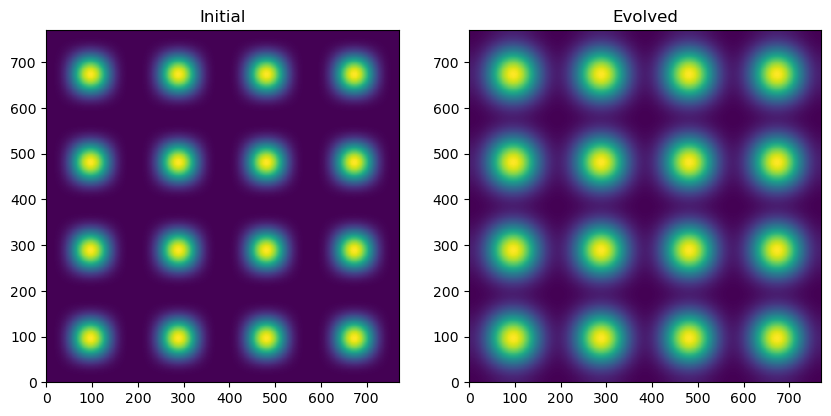

In [54]:
plot_grids(init(), solution_numba)

### Applying @jit to NumPy expressions
* Numba is aware of a (growing) number of NumPy functions
    * not aware of `roll()`
    * not aware of the SciPy Laplacian
    * but well aware of NumPy array notation
* Numba is able to parallelize some NumPy expressions

In [55]:
@njit
def apply_periodic_bc_numba(grid, n_points):
    """Explicitly apply periodic boundary conditions, using NumPy ranges."""
    grid[ 0, :] = grid[-2, :]
    grid[-1, :] = grid[ 1, :]
    grid[ :,-1] = grid[ :, 1]
    grid[ :, 0] = grid[ :,-2]

In [56]:
set_num_threads(2)

@njit(parallel=True)
def evolve_np_slicing_numba_parallel(grid, grid_tmp, n_points, dt, D):
    """Time step based on an explicitly coded Laplacian using array slicing."""
    apply_periodic_bc_numba(grid, n_points)
    grid_tmp[1:-1, 1:-1] = grid[1:-1, 1:-1] \
                     + dt * D * (   grid[0:-2, 1:-1] + grid[2:  , 1:-1] \
                                  + grid[1:-1, 0:-2] + grid[1:-1, 2:  ] \
                                  - 4.0 * grid[1:-1, 1:-1] )

In [57]:
grid = init(with_ghosts=True)
solution_numba = main_loop(evolve_np_slicing_numba_parallel, grid)

In [58]:
%%time
grid = init(with_ghosts=True)
solution_numba = main_loop(evolve_np_slicing_numba_parallel, grid)

CPU times: user 2.69 s, sys: 3.85 ms, total: 2.69 s
Wall time: 1.35 s


In [ ]:
assert(np.allclose(solution_scipy, solution_numba[1:-1,1:-1]))

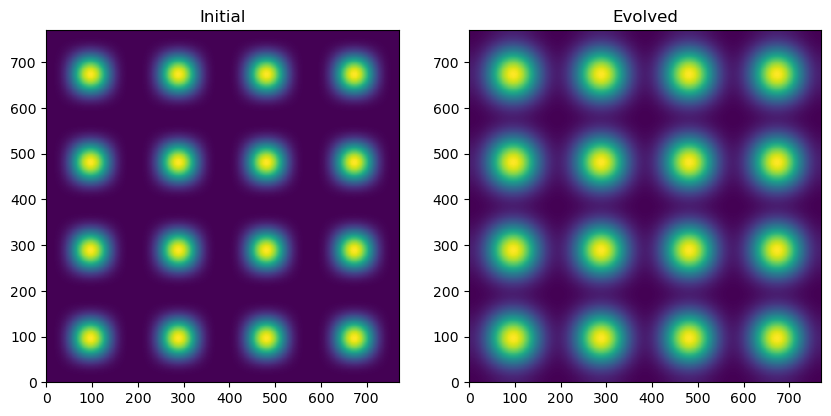

In [59]:
plot_grids(init(), solution_numba)

## Numba's `stencil` decorator
* define stencil functions using a simple single-element notation relative to `[0, 0]`
* boundaries are set to `0.`
* stencil functions are applied to a whole array

In [60]:
from numba import njit, set_num_threads
from numba import stencil

set_num_threads=2

@stencil
def numba_stencil(grid, dt, D):
    return grid[0, 0] + dt * D * (grid[-1, 0] + grid[1, 0] + grid[0, -1] + grid[0, 1] - 4.0 * grid[0, 0])

@njit(parallel=True)
def evolve_numba_stencil(grid, grid_tmp, n_points, dt, D):
    apply_periodic_bc_numba(grid, n_points)
    grid_tmp[:] = numba_stencil(grid, dt, D)

In [61]:
grid = init(with_ghosts=True)
solution_numba_stencil = main_loop(evolve_numba_stencil, grid)

In [62]:
%%time
grid = init(with_ghosts=True)
solution_numba_stencil = main_loop(evolve_numba_stencil, grid)

CPU times: user 5.64 s, sys: 47.5 ms, total: 5.69 s
Wall time: 2.85 s


In [ ]:
assert(np.allclose(solution_scipy, solution_numba_stencil[1:-1,1:-1]))

In [63]:
plot_grids(init(), solution_numba_stencil)

## Numba summary
* Numba may accelerate your code significantly
* Numba works very well with naive Python loops
* Numba speeds up certain NumPy array expressions, may even parallelize them
* Advantage: Python code compatibility is preserved
* Disadvantage: Debugging rather complex in case @jit does not work as expected

## Jax
* Jax is a library for just-in-time compiler (based on XLA) and autodifferentiation
* usage via the decorator `@jit`

### Numpy in-place updates with jax
* jax **doesn't** support inplace updates
* **but** there is a functional replacement on arrays wit the `.at` operator: `x.at[idx].set(y)` returning a copy
* **and** if `x` is not reused (i.e. `x = x.at[idx].set(y)`) the compiled operation will happen in place

In [64]:
import jax.numpy as np

def main_loop_jax(evolve_func, grid):
    """Main loop function, calling evolve_func on grid."""
    for i in range(1, n_iterations+1):
        grid = evolve_func(grid, n_points, dt, D)
    return grid

In [65]:
from jax import jit

# just redefined as before but with jax.numpy
def laplacian_np_roll(grid):
    """Laplacian implementation based on the NumPy roll functionality."""
    return np.roll(grid, +1, 0) + np.roll(grid, -1, 0) \
         + np.roll(grid, +1, 1) + np.roll(grid, -1, 1) \
         - 4 * grid

@jit
def evolve_np_roll_jax(grid, n_points, dt, D):
    """Time step based on the NumPy-roll-Laplacian."""
    return grid.at[:].set(grid + dt * D * laplacian_np_roll(grid))

In [66]:
grid = init(with_ghosts=False)
solution_jax = main_loop_jax(evolve_np_roll_jax, grid)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [67]:
%%timeit
grid = init(with_ghosts=False)
solution_jax = main_loop_jax(evolve_np_roll_jax, grid)

998 ms ± 149 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
assert(np.allclose(solution_scipy, solution_jax))

In [68]:
plot_grids(init(), solution_jax)